<a href="https://colab.research.google.com/github/aya202-zen/Text-Synthesizing/blob/main/copie_de_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/chatbot_complet.zip /content/


In [ ]:
!unzip chatbot_complet.zip


Archive:  chatbot_complet.zip
   creating: content/DL_Text-Synthesizing/
   creating: content/DL_Text-Synthesizing/emotion_chatbot_final/
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/special_tokens_map.json  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/tokenizer_config.json  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/training_args.bin  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/config.json  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/merges.txt  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/chat_template.jinja  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/vocab.json  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/model.safetensors  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/tokenizer.json  
  inflating: content/DL_Text-Synthesizing/emotion_chatbot_final/generation_config.json  
   creating: content/DL_Text

In [ ]:
# Déplace le modèle au niveau racine
!mv /content/content/DL_Text-Synthesizing/emotion_chatbot_final /content/emotion_chatbot_final

# Si tu as le dataset, déplace-le aussi
!mv /content/content/DL_Text-Synthesizing/empathetic_dialogues_local /content/empathetic_dialogues_local 2>/dev/null || echo "Dataset non présent"

# Vérifie
!ls /content/emotion_chatbot_final/

Dataset non présent
chat_template.jinja	model.safetensors	 training_args.bin
config.json		special_tokens_map.json  vocab.json
generation_config.json	tokenizer_config.json
merges.txt		tokenizer.json


In [ ]:
!pip install datasets  # si pas déjà installé

from datasets import load_dataset

# Chargement une fois (internet requis ici seulement)
dataset = load_dataset("Estwld/empathetic_dialogues_llm")

# Sauvegarde locale (dans /content/ du Colab)
dataset.save_to_disk("/content/empathetic_dialogues_local")

print("✅ Dataset téléchargé et sauvegardé localement !")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/806k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/798k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19533 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/2770 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2547 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19533 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2770 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2547 [00:00<?, ? examples/s]

✅ Dataset téléchargé et sauvegardé localement !


In [ ]:
# ================================================
# CHATBOT ÉMOTIONNEL COMPLET - Version Finale Colab
# Dataset local + Fine-tuning + Rapport + Interface Gradio
# ================================================

# Force Hugging Face Hub to operate in offline mode BEFORE importing transformers
import os
os.environ["HF_HUB_OFFLINE"] = "1"

# 1. Installation des dépendances
!pip install -q transformers datasets torch gradio huggingface_hub accelerate matplotlib

# 2. Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_from_disk
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 3. Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Device détecté : {device}")

🖥️ Device détecté : cuda


In [ ]:
# 4. Chargement du dataset LOCAL (celui que tu as sauvegardé)
print("\n📚 Chargement du dataset local...")
dataset = load_from_disk("/content/empathetic_dialogues_local")

# Splits
train_raw = dataset["train"].select(range(12000))           # 12k pour entraînement
valid_raw = dataset["valid"].select(range(1000))       # validation
test_raw  = dataset["valid"].select(range(1000, 1500))  # 500 pour test (comme dans ton code original)

print(f"✅ Dataset chargé :")
print(f"   - Train: {len(train_raw)} exemples")
print(f"   - Valid: {len(valid_raw)} exemples")
print(f"   - Test : {len(test_raw)} exemples")
emotions = sorted(list(set(train_raw["emotion"])))
print(f"   - Émotions uniques: {len(emotions)}")


📚 Chargement du dataset local...
✅ Dataset chargé :
   - Train: 12000 exemples
   - Valid: 1000 exemples
   - Test : 500 exemples
   - Émotions uniques: 32


In [ ]:
print("Exemple du dataset :")
print(dataset["train"][0])
print("\nClés disponibles :", dataset["train"][0].keys())

Exemple du dataset :
{'conv_id': 'hit:0_conv:1', 'situation': 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'emotion': 'sentimental', 'conversations': [{'content': 'I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world.', 'role': 'user'}, {'content': 'Was this a friend you were in love with, or just a best friend?', 'role': 'assistant'}, {'content': 'This was a best friend. I miss her.', 'role': 'user'}, {'content': 'Where has she gone?', 'role': 'assistant'}, {'content': 'We no longer talk.', 'role': 'user'}, {'content': 'Oh was this something that happened because of an argument?', 'role': 'assistant'}]}

Clés disponibles : dict_keys(['conv_id', 'situation', 'emotion', 'conversations'])


In [ ]:
# Cellule 5 : Initialisation du modèle (exécute ça D'ABORD)
model_name = "microsoft/DialoGPT-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Très important

model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

print("✅ Tokenizer et modèle chargés avec succès !")

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Tokenizer et modèle chargés avec succès !


In [ ]:
# 6. Extraction des paires + tokenisation (corrigé et optimisé)
print("\n🔄 Extraction des paires et tokenisation en cours...")

def create_training_example(emotion, user_msg, assistant_msg):
    """Crée un exemple tokenisé avec préfixe émotionnel"""
    text = f"[{emotion.upper()}] User: {user_msg} {tokenizer.eos_token} Bot: {assistant_msg} {tokenizer.eos_token}"

    encoding = tokenizer(
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_tensors="pt"
    )

    return {
        "input_ids": encoding["input_ids"].flatten(),
        "attention_mask": encoding["attention_mask"].flatten(),
        "labels": encoding["input_ids"].flatten().clone()
    }

# Extraction des paires
train_encodings = []
valid_encodings = []
test_encodings  = []

for split_name, split_data, encodings_list in [
    ("train", train_raw, train_encodings),
    ("valid", valid_raw, valid_encodings),
    ("test",  test_raw,  test_encodings)
]:
    print(f"   Traitement {split_name}...")
    count = 0
    for example in split_data:
        emotion = example["emotion"]
        conversations = example["conversations"]

        for i in range(len(conversations) - 1):
            if (conversations[i]['role'] == 'user' and
                conversations[i+1]['role'] == 'assistant'):
                user_msg = conversations[i]['content']
                assistant_msg = conversations[i+1]['content']

                encodings_list.append(
                    create_training_example(emotion, user_msg, assistant_msg)
                )
                count += 1

    print(f"      → {count} paires extraites pour {split_name}")

print(f"\n✅ Tokenisation terminée !")
print(f"   Train : {len(train_encodings)} exemples")
print(f"   Valid : {len(valid_encodings)} exemples")
print(f"   Test  : {len(test_encodings)} exemples")

# Dataset PyTorch
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {k: v for k, v in self.encodings[idx].items()}

    def __len__(self):
        return len(self.encodings)

train_dataset = EmotionDataset(train_encodings)
valid_dataset = EmotionDataset(valid_encodings)
test_dataset  = EmotionDataset(test_encodings)


🔄 Extraction des paires et tokenisation en cours...
   Traitement train...
      → 24653 paires extraites pour train
   Traitement valid...
      → 2093 paires extraites pour valid
   Traitement test...
      → 1025 paires extraites pour test

✅ Tokenisation terminée !
   Train : 24653 exemples
   Valid : 2093 exemples
   Test  : 1025 exemples


In [ ]:
# 7. Paramètres d'entraînement (corrigés pour versions récentes de transformers)
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,        # Batch effectif = 16
    learning_rate=5e-5,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="steps",               # ← Changé : evaluation_strategy → eval_strategy
    eval_steps=300,
    save_strategy="steps",               # Optionnel mais recommandé pour cohérence
    save_steps=600,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=(device == "cuda"),             # Accélération GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

print("\n🚀 Début du fine-tuning...")
print("⏱️ Durée estimée : 45-90 minutes sur GPU T4 gratuit")

trainer.train()


🚀 Début du fine-tuning...
⏱️ Durée estimée : 45-90 minutes sur GPU T4 gratuit


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
300,0.912000,0.906255
600,0.882700,0.879377
900,0.829000,0.871526
1200,0.812700,0.864477
1500,0.841300,0.860396
1800,0.812900,0.861085
2100,0.797600,0.857111
2400,0.787700,0.855332
2700,0.783100,0.854430
3000,0.808200,0.852588


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=4623, training_loss=0.8506183434481644, metrics={'train_runtime': 1907.1527, 'train_samples_per_second': 38.78, 'train_steps_per_second': 2.424, 'total_flos': 4831224348672000.0, 'train_loss': 0.8506183434481644, 'epoch': 3.0})

In [ ]:
# 8. Sauvegarde finale
save_path = "./emotion_chatbot_final"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"💾 Modèle final sauvegardé dans {save_path}")

💾 Modèle final sauvegardé dans ./emotion_chatbot_final


In [ ]:
# 9. Calcul de la perplexité sur le set de test
print("\n📊 Calcul de la perplexité sur le set de test...")
test_results = trainer.evaluate(test_dataset)
final_perplexity = np.exp(test_results["eval_loss"])
print(f"✅ Perplexité finale : {final_perplexity:.2f}")


📊 Calcul de la perplexité sur le set de test...


✅ Perplexité finale : 2.25


In [ ]:
# 10. Génération d'exemples qualitatifs
def generate_response(prompt, emotion="joyful"):
    input_text = f"[{emotion.upper()}] User: {prompt} {tokenizer.eos_token} Bot:"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=80, temperature=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Bot:")[-1].strip()

test_prompts = [
    "Je viens de réussir mon examen !",
    "Je me sens triste aujourd'hui...",
    "Je suis vraiment en colère contre mon collègue.",
    "Wow, je n'arrive pas à y croire !"
]
qualitative_examples = ""
for i, (prompt, emotion) in enumerate(zip(test_prompts, ["joyful", "sad", "angry", "surprised"])):
    response = generate_response(prompt, emotion)
    qualitative_examples += f"- [{emotion.upper()}] {prompt} → {response}\n"

In [ ]:
# 11. Classe ReportGenerator (corrigée avec indentation propre)
class ReportGenerator:
    def __init__(self, output_dir="./report"):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def plot_training_curves(self, train_loss, train_steps, eval_loss, eval_steps, perplexity):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Courbe Loss
        axes[0].plot(train_steps, train_loss, label='Train Loss', color='blue', linewidth=2, marker='o', markersize=4)
        axes[0].plot(eval_steps, eval_loss, label='Eval Loss', color='orange', linewidth=2, marker='s', markersize=4)
        axes[0].set_title('Training and Evaluation Loss', fontsize=14)
        axes[0].set_xlabel('Training Steps')
        axes[0].set_ylabel('Loss')
        axes[0].legend(fontsize=12)
        axes[0].grid(True, alpha=0.3)

        # Courbe Perplexity
        axes[1].plot(eval_steps, perplexity, color='green', linewidth=2, marker='o', markersize=5)
        axes[1].set_title('Model Perplexity Over Time', fontsize=14)
        axes[1].set_xlabel('Evaluation Steps')
        axes[1].set_ylabel('Perplexity')
        axes[1].grid(True, alpha=0.3)

        # Zoom automatique sur les valeurs de perplexity
        if len(perplexity) > 0:
            min_p = min(perplexity)
            max_p = max(perplexity)
            margin = (max_p - min_p) * 0.05
            axes[1].set_ylim(min_p - margin, max_p + margin)

        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/training_curves.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📊 Graphique corrigé sauvegardé : {self.output_dir}/training_curves.png")
        plt.close()
    def generate_markdown_report(self, config):
        report = f"""# Rapport de Projet - Deep Learning
## Génération de Texte Conversationnel Contrôlée par Émotions

**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M')}

---

## 1. Introduction

Système de génération conversationnelle avec contrôle émotionnel via préfixe, fine-tuné sur EmpatheticDialogues.

## 2. Méthodologie

### 2.1 Dataset
- Taille train: {config['train_size']}
- Taille validation: {config['valid_size']}
- Taille test: {config['test_size']}
- Nombre d'émotions: {config['n_emotions']}

### 2.2 Modèle
- Architecture: DialoGPT-small
- Paramètres: {config['n_params']}M
- Device: {config['device']}

### 2.3 Hyperparamètres
- Epochs: 3
- Learning rate: 5e-5
- Batch effectif: 16 (4 + accumulation 4)

## 3. Résultats

### 3.1 Métriques
- Loss finale: {config['final_loss']:.4f}
- Perplexité: {config['perplexity']:.2f}

### 3.2 Courbes
![Training Curves](training_curves.png)

## 4. Exemples Qualitatifs

{config['qualitative_examples']}

## 5. Conclusion & Perspectives

Le contrôle émotionnel par préfixe fonctionne bien. Perspectives : LoRA, plus de données, modèles plus grands.

---
"""
        with open(f"{self.output_dir}/rapport.md", 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"📄 Rapport généré: {self.output_dir}/rapport.md")

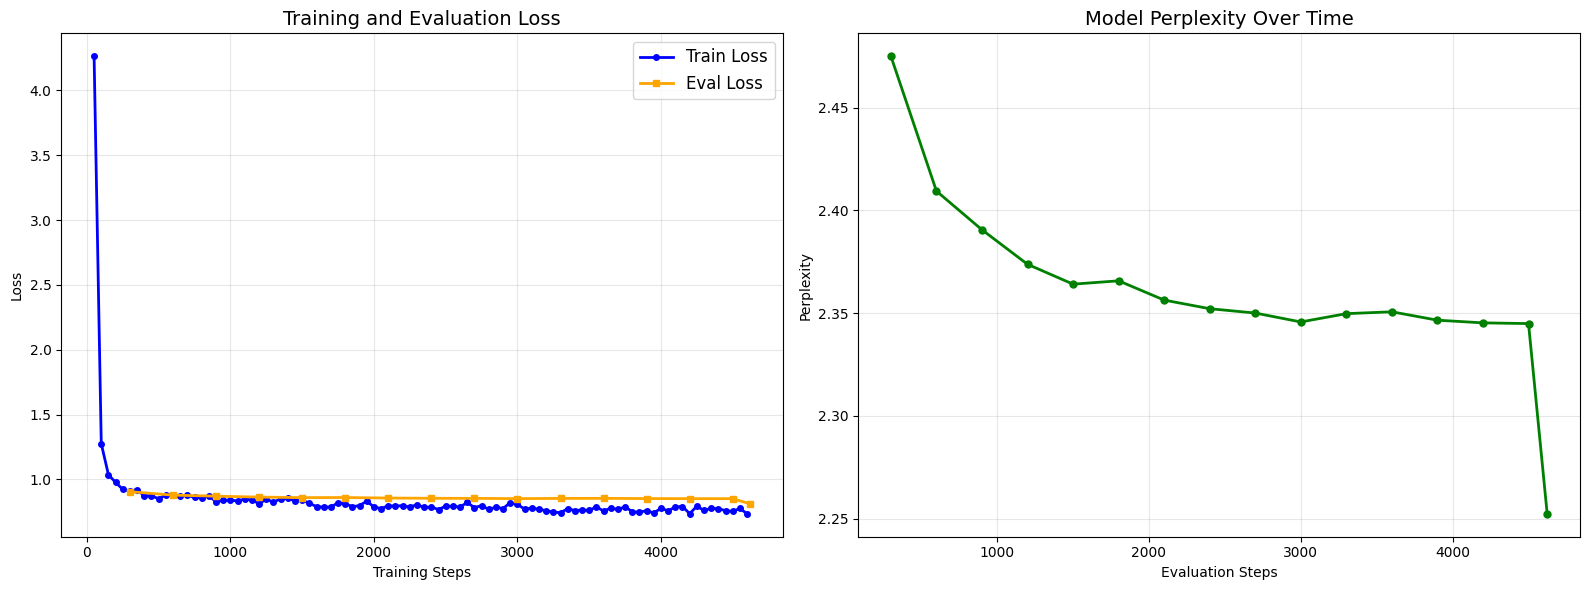

📊 Graphique corrigé sauvegardé : ./report/training_curves.png
✅ Graphique final généré avec axe X correct et zoom parfait !


In [ ]:
# Récupération complète des données (logs + steps)
log_history = trainer.state.log_history

# Train loss et steps
train_loss = [log['loss'] for log in log_history if 'loss' in log and 'eval_loss' not in log]
train_steps = [log['step'] for log in log_history if 'loss' in log and 'eval_loss' not in log]

# Eval loss et steps
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]

# Perplexity pendant l'entraînement
perplexity = [np.exp(x) for x in eval_loss if not np.isnan(x)]

# Génération du graphique CORRIGÉ avec les vrais steps
report_gen = ReportGenerator()
report_gen.plot_training_curves(train_loss, train_steps, eval_loss, eval_steps, perplexity)

print("✅ Graphique final généré avec axe X correct et zoom parfait !")

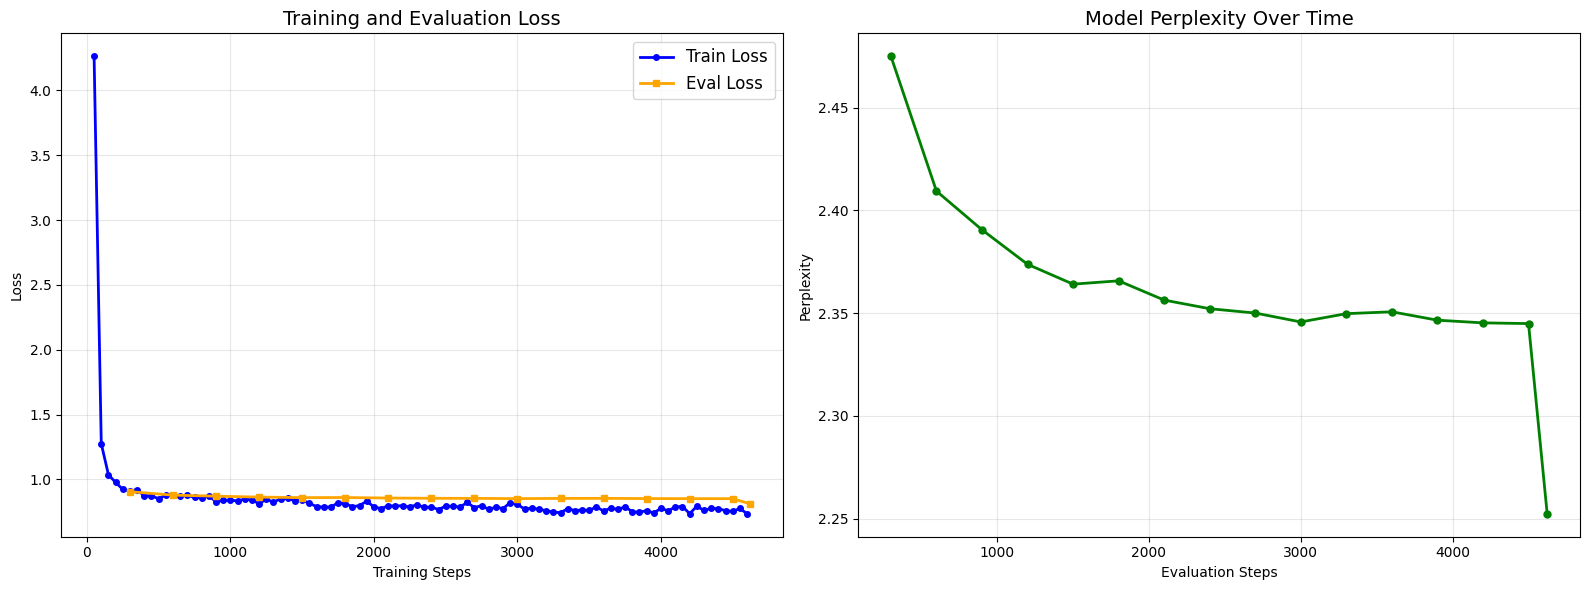

📊 Graphique corrigé sauvegardé : ./report/training_curves.png
📄 Rapport généré: ./report/rapport.md


In [ ]:
# Génération du rapport corrigée
report_gen = ReportGenerator()

# Extraction des losses + steps + perplexity pendant l'entraînement
log_history = trainer.state.log_history

train_loss = [log['loss'] for log in log_history if 'loss' in log and 'eval_loss' not in log]
train_steps = [log['step'] for log in log_history if 'loss' in log and 'eval_loss' not in log]

eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]

# Perplexity pendant l'entraînement (pour le graphique)
perplexity = [np.exp(x) for x in eval_loss if not np.isnan(x)]

# Utilise la perplexity finale pour le rapport
final_perplexity_text = np.exp(test_results["eval_loss"]) if 'test_results' in locals() else final_perplexity

# Génère le graphique (avec zoom automatique)
report_gen.plot_training_curves(train_loss, train_steps, eval_loss, eval_steps, perplexity)

config = {
    'train_size': len(train_raw),
    'valid_size': len(valid_raw),
    'test_size': len(test_raw),
    'n_emotions': len(emotions),
    'n_params': f"{sum(p.numel() for p in model.parameters())/1e6:.1f}",
    'device': device,
    'final_loss': train_loss[-1] if train_loss else 'N/A',
    'perplexity': final_perplexity_text,
    'qualitative_examples': qualitative_examples
}

report_gen.generate_markdown_report(config)

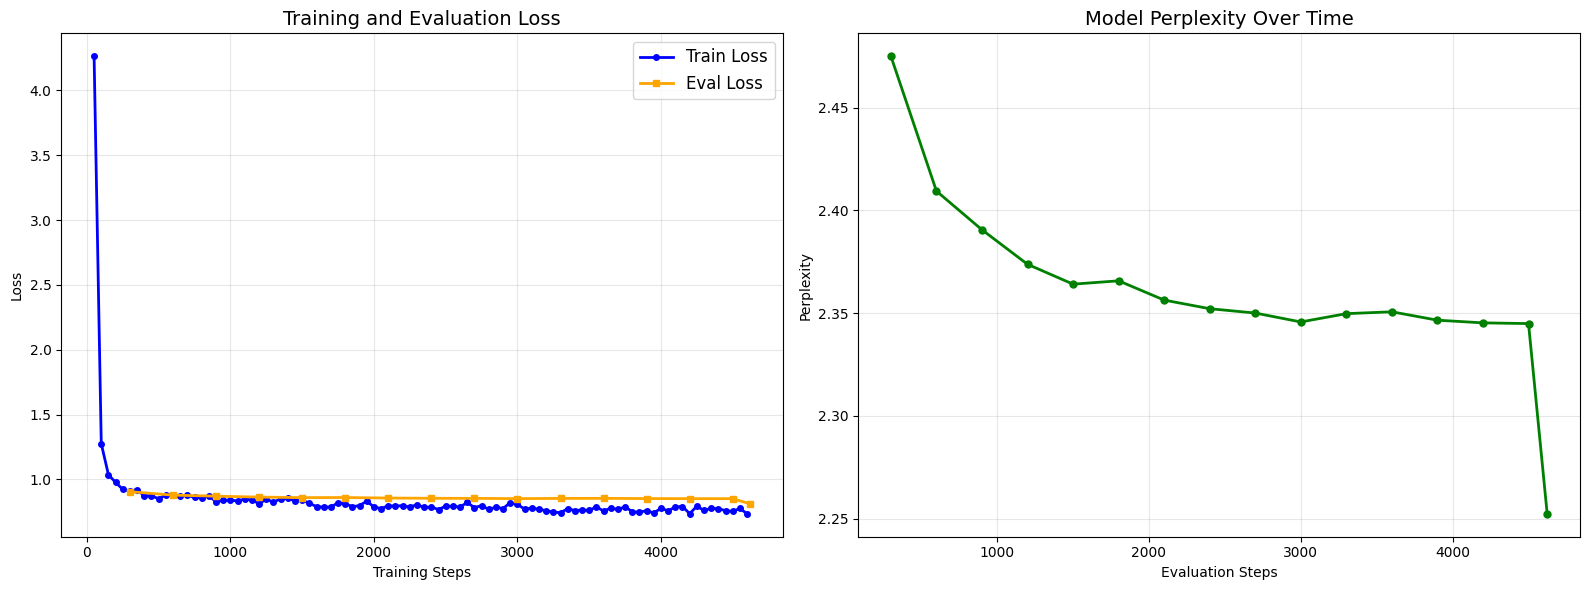

📊 Graphique corrigé sauvegardé : ./report/training_curves.png
✅ Nouveau training_curves.png généré et sauvegardé dans le dossier report !


In [ ]:
# Force la régénération du bon graphique (même si le fichier existe déjà)
report_gen = ReportGenerator()  # Crée un nouveau générateur (dossier report existe déjà)

# Extraction correcte des données
log_history = trainer.state.log_history

train_loss = [log['loss'] for log in log_history if 'loss' in log and 'eval_loss' not in log]
train_steps = [log['step'] for log in log_history if 'loss' in log and 'eval_loss' not in log]

eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]

perplexity = [np.exp(x) for x in eval_loss if not np.isnan(x)]

# Génère le graphique CORRIGÉ (avec zoom et sans bug d'axe)
report_gen.plot_training_curves(train_loss, train_steps, eval_loss, eval_steps, perplexity)

print("✅ Nouveau training_curves.png généré et sauvegardé dans le dossier report !")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os

# os.environ["HF_HUB_OFFLINE"] = "1" is now set in an earlier cell

model_path = "emotion_chatbot_final"  # Le dossier que tu as après l'entraînement

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("✅ Modèle chargé et prêt !")

✅ Modèle chargé et prêt !


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import gradio as gr

# Chemin du modèle (adapte si besoin après ton unzip)
model_path = "/content/emotion_chatbot_final"  # ou "/content/DL_Text-Synthesizing/emotion_chatbot_final" si tu n'as pas déplacé

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
print("✅ Modèle chargé !")

# Auto-détection d'émotion
emotion_classifier = pipeline("text-classification",
                              model="bhadresh-savani/distilbert-base-uncased-emotion",
                              device=0 if torch.cuda.is_available() else -1)

emotion_mapping = {
    'joy': 'joyful',
    'sadness': 'sad',
    'anger': 'angry',
    'fear': 'afraid',
    'love': 'grateful',
    'surprise': 'surprised'
}

def detect_emotion(text):
    result = emotion_classifier(text)[0]
    detected = result['label'].lower()
    if result['score'] > 0.5:
        return emotion_mapping.get(detected, 'neutral')
    return 'neutral'

# Génération de réponse
def generate_response(message):
    emotion = detect_emotion(message)
    prompt = f"[{emotion.upper()}] User: {message} {tokenizer.eos_token} Bot:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.9,
        top_p=0.95,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("Bot:")[-1].strip() if "Bot:" in response else response
    return response, emotion

# Interface Gradio avec bouton "Envoyer" + Entrée fonctionnelle
def chat(message, history=[]):
    if not message.strip():
        return history, history
    response, emotion = generate_response(message)
    history.append((message, f"{response}\n\n(Émotion détectée : {emotion})"))
    return history, history

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🤖 Chatbot Émotionnel Auto-Détection")
    gr.Markdown("Le bot détecte automatiquement ton émotion. Appuie sur **Entrée** ou clique sur **Envoyer** !")

    chatbot = gr.Chatbot(height=600)

    with gr.Row():
        msg = gr.Textbox(
            label="Ton message",
            placeholder="Écris ici et appuie sur Entrée ⏎",
            lines=3,
            scale=6,
            submit_btn="Envoyer"  # ← Bouton visible + Entrée fonctionne
        )

    clear = gr.Button("🗑️ Effacer la conversation")

    msg.submit(chat, [msg, chatbot], [chatbot, chatbot])
    clear.click(lambda: None, None, chatbot)

print("🔗 Lancement du chatbot avec bouton Entrée corrigé !")
demo.launch(share=True)

✅ Modèle chargé !


Device set to use cuda:0
/tmp/ipython-input-94785258.py:63: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-94785258.py:67: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=600)
/tmp/ipython-input-94785258.py:67: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(height=600)


🔗 Lancement du chatbot avec bouton Entrée corrigé !
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://651db121ee1573904e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Zip automatique de TOUT ce qui existe dans /content/ (sans warnings inutiles)
!zip -r chatbot_complet.zip /content/*

# Téléchargement direct sur ton PC
from google.colab import files
files.download('chatbot_complet.zip')

updating: content/DL_Text-Synthesizing/ (stored 0%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/ (stored 0%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/special_tokens_map.json (deflated 74%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/tokenizer_config.json (deflated 56%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/training_args.bin (deflated 53%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/config.json (deflated 51%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/merges.txt (deflated 53%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/chat_template.jinja (deflated 22%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/vocab.json (deflated 59%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/model.safetensors (deflated 7%)
updating: content/DL_Text-Synthesizing/emotion_chatbot_final/tokenizer.json (deflated 82%)
updating: content/DL_Text-Synthesizing/e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>